# ADA final exam (Fall 2023)

This exam consists of 2 parts. Parts are independent from each other.

## Dataset


"Friends" is an American television sitcom that originally aired on NBC from September 22, 1994, to May 6, 2004. Created by David Crane and Marta Kauffman, the show gained immense popularity and has since become a classic in the world of television. The series is set in New York City and revolves around a group of six friends: Ross Geller (David Schwimmer), Rachel Green (Jennifer Aniston), Monica Geller (Courteney Cox), Chandler Bing (Matthew Perry), Joey Tribbiani (Matt LeBlanc), and Phoebe Buffay (Lisa Kudrow). The show explores their personal and professional lives as they navigate the ups and downs of relationships, careers, and the challenges of adulthood.

In this exam, we will use a dataset containing all the conversations that occurred over 10 seasons of Friends. We refer to each row in the dataset as an 'utterance." The data format of the dataset is as follows

- id: `<str>`, the index of the utterance in the format sAA_eBB_cCC_uDDD, where AA is the season number, BB is the episode number, CC is the scene/conversation number, and DDD is the number of the utterance in the scene (e.g. s01_e18_c05_u021).
- speaker: `<str>`, the speaker who made the utterance, e.g. Monica Geller
- conversation_id: `<str>`, the id of the first utterance in the conversation this utterance belongs. We assume conversations begin at the start of a new scene.
- reply_to: `<str>`, the id of the utterance to which this utterance replies. None if the utterance is the first in a conversation.
- text: `<str>`, the textual content of the utterance.


In [1]:
# First, let's import some required libraries!
import statsmodels.formula.api as smf
import pandas as pd
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np


## Part 1: The one where you find the protagonist (60 pts)

A big debate among Friends fans is: who is the show's main character? In this task, your goal is to provide a data-driven answer to this question.


--- 

**1.1 —** Load the data from the jsonl file `exam1.jsonl` into a pandas dataframe. Then
 
 A. Calculate and display the number of distinct speakers in the dataframe.
 
 B. Calculate and display the number of conversations (see `conversation_id`).
 
 C. Remove all utterances from the dataframe where the `speaker` is "TRANSCRIPT_NOTE" or "#ALL#". Print the number of rows in the dataframe.
 
 D. Create additional columns corresponding to the season (`season`, e.g., season 1 should contain `s01`) and the episode (`episode`, e.g., episode 5 of season 4 should contain `s04_e05`) of each utterance. Print the season and the episode associated with utterance `s10_e18_c11_u019`.
 
 E. Create an additional column corresponding to the length of each utterance in terms of the number of characters (`length`). Print the length associated with utterance `s10_e18_c11_u019`.


In [2]:
exam1_df = pd.read_json("exam1.jsonl", lines = True)
exam1_df.head()

,id,conversation_id,text,speaker,reply-to
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003
4,s01_e01_c01_u005,s01_e01_c01_u001,,TRANSCRIPT_NOTE,s01_e01_c01_u004


In [3]:
#1.1.A
n_unique_speaker = exam1_df['speaker'].unique().shape[0] 
print(f"There are {n_unique_speaker} unique speakers.")

#1.1.B
n_unique_conv = exam1_df['conversation_id'].unique().shape[0] 
print(f"There are {n_unique_conv} unique conversations.")

#1.1.C
exam1_df = exam1_df[exam1_df['speaker'] != "TRANSCRIPT_NOTE"]
exam1_df = exam1_df[exam1_df['speaker'] != "#ALL#"]
n_rows = exam1_df.shape[0]
print(f"There are {n_rows} rows in the dataframe.")

#1.1.D 
exam1_df['season'] = exam1_df['id'].apply(lambda x: x[0:3])
exam1_df['episode'] = exam1_df['id'].apply(lambda x: x[4:7])
##exam1_df.head() for verification
s10_e18_c11_u019 = exam1_df[exam1_df['id'] == 's10_e18_c11_u019'].reset_index()
print(s10_e18_c11_u019.loc[0, 'season'], s10_e18_c11_u019.loc[0, 'episode'])

#1.1.E
exam1_df['length'] = exam1_df['text'].apply(lambda x: len(list(x)))
s10_e18_c11_u019 = exam1_df[exam1_df['id'] == 's10_e18_c11_u019'].reset_index()
print(s10_e18_c11_u019.loc[0, 'length'])

There are 700 unique speakers.
There are 3107 unique conversations.
There are 60985 rows in the dataframe.
s10 e18
17


In [4]:
exam1_df.head()

,id,conversation_id,text,speaker,reply-to,season,episode,length
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01,e01,56
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01,e01,80
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01,e01,72
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,s01,e01,24
5,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,s01,e01,79


**1.2** Next, you conduct some basic analyses:

 A. With `statsmodels`, fit a linear regression `length ~ C(season, Treatment(reference="s01"))`, where length is an integer and season is a categorical variable. Print the regression summary.
 
 B. /**Discuss:/** Considering the regression summary:
   - What does the intercept in this regression represent? 
   - What does the coefficient `C(season, Treatment(reference="s01"))[T.s09]` represent? 
   - Does the average utterance in season 9 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary **only**. 
   - Does the average utterance in season 10 contain significantly more characters than in season 1 at the 0.05 significance level? Justify with the regression summary  **only** .

 C. Argue visually (i.e., with a plot) that there are 6 main characters in the show.

In [5]:
# 1.2.A
mod = smf.ols(formula='length ~ C(season, Treatment(reference="s01"))', data=exam1_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.058
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           4.96e-12
Time:                        18:17:15   Log-Likelihood:            -3.2981e+05
No. Observations:               60985   AIC:                         6.596e+05
Df Residuals:                   60975   BIC:                         6.597e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

#### 1.2.B
The intercept in this regression represents the standard average length of an utterance in season 1. C(season, Treatment(reference="s01"))[T.s09] represents the impact that the length of the utterances in season 9 on the overall model. In this case, it also represents the difference in aerage utterance length in characters between season 1 and 9 utterances. Season 9 does cntan singificantly more characters as the coefficient is positive and the pvalue is null. This is not the case for season 10 where the coefficient is not only negative but has a p-value of 0.681. 

Text(0.5, 1.0, 'Utterance number distribution amongst the characters of the show')

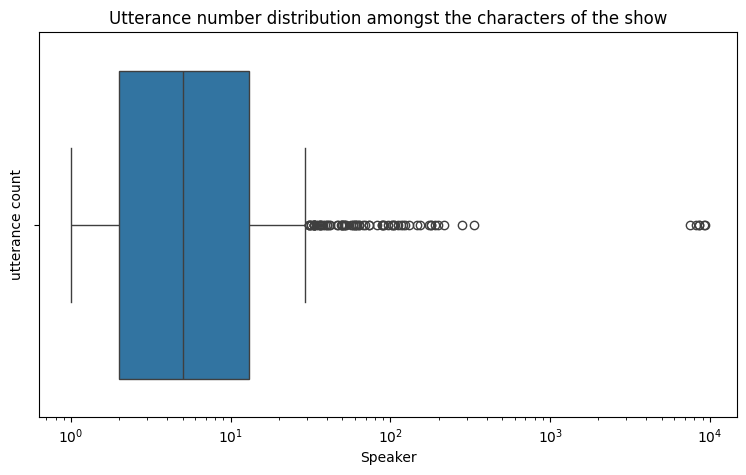

In [6]:
#1.2.C
utterance_per_character = exam1_df.groupby('speaker')['id'].count().reset_index() ## main characters will speak the most frequently 

plt.figure(figsize = (9,5))
sns.boxplot(utterance_per_character, x='id')
plt.xlabel("Speaker")
plt.xscale("log")
plt.ylabel("utterance count")
plt.title("Utterance number distribution amongst the characters of the show")

--- 
**1.3 —** Using `networkx` 

A. Create a `MultiDiGraph` (directed graph with self loops and parallel edges) where:
- Each node $u$ is a character uniquely identified by the `speaker` field.
- There is an edge between nodes $u$ and $v$ if $u$ replied to $v$. If an utterance (a row in the dataframe) is said in reply to nobody, then it will not correspond to an edge. Each edge should contain two attributes. Each edge should have two attributes: `season` and `episode`.

B. Print the number of nodes and edges in your graph.

C. **/Discuss:/** Instead of using multi-edges, what would be another way in which you could capture the number of replies associated with each node pair?


One could have used weighed edges instead of a multi-directional graph. The more a characetr speaks to another, the higher the weight of the edge.

---
With the graph ready, you set out to investigate who is the true protagonist of Friends.

Ignore the graph you generated previously and instead use the graph provided in `exam2.graphml`. Note that this graph may be slightly different from what you generated, but treat it as the ground truth. We provide you with code to load the graph below.


---

**1.4 —** Using the provided MultiDiGraph $G$:

A. Calculate the out-degree of each node (also known as out-degree centrality). Please do not use the `nx.out_degree_centrality` function here, as it normalizes the degree. (E.g., if a node has 5 outgoing edges, it should have out-degree 5 according to your code.)

B. Calculate the PageRank centrality of each node in $G$. Use the default parameters.

C. Print both centrality metrics calculated above for the six main characters of Friends.

D. **/Discuss:/** According to the metrics, who is the most important character in Friends?

In [7]:
G = nx.read_graphml("exam2.graphml")

#1.4.A
out_degrees = G.out_degree()
print(out_degrees)

#1.4.B
G_pr = nx.pagerank(G)
#1.4.C
main_6 = ['Ross Geller', 'Rachel Green', 'Monica Geller', 'Chandler Bing', 'Joey Tribbiani', 'Phoebe Buffay']
for main in main_6:
    print(f"{main}'s out degree is {out_degrees[main]} and page rank is {G_pr[main]}")

[('Joey Tribbiani', 7395), ('Monica Geller', 7621), ('Chandler Bing', 7702), ('Phoebe Buffay', 6797), ('Ross Geller', 8234), ('Rachel Green', 8470), ('Waitress', 6), ('Paul the Wine Guy', 14), ('Priest On Tv', 0), ('Franny', 6), ('Customer', 12), ('Marsha', 4), ('Carol Willick', 183), ('Judy Geller', 154), ('Susan Bunch', 94), ('Barry Farber', 35), ('Robbie', 4), ('Bernice', 3), ('Dr. Oberman', 3), ('Paula', 6), ('Alan', 4), ('The Guys', 9), ('Lizzy', 10), ('Leslie', 17), ('Guys', 4), ('Kiki', 4), ('Joanne', 5), ('Receptionist', 30), ('Pizza Guy', 8), ('Both', 15), ('Kid', 7), ('Angela Delveccio', 10), ('Janice Litman Goralnik', 189), ('Woman', 89), ('Bob', 7), ('Aurora', 28), ('Director', 49), ('Jill Goodacre', 8), ('Mr. Heckles', 31), ('Paolo', 18), ('Shelley', 11), ('Aunt Lillian', 8), ('Nurse Sizemore', 12), ('Andrea', 2), ('Lowell', 7), ('Terry', 18), ('Guy', 54), ('Girl', 23), ('Max', 12), ('David', 116), ('Sandy', 29), ('Bobby Rush', 28), ('Dick Clark', 2), ('Jay Leno', 4), ('No

#### 1.4.D
According to the metrics above, the main character appears to be Rachel as she possesses the largest out degree and page rank out of any of the 6.

---

**1.5 —** **/True or false:/** Considering your answer in **1.4**, are the following statements true or false? Justify your answers. 

A. "If we inverted all  edges in the graph such that an edge $(u,v)$ becomes an edge $(v,u)$, the PageRank centrality would remain unchanged."

B. "If we removed all outgoing edges from Rachel Green, her PageRank centrality would remain unchanged."

C. "If a new node was introduced in the graph, with 1,000 outgoing edges towards each other node, but no incoming edge, it would have the highest PageRank centrality."


 - A: False, page rank is computed by counting the number of incoming edges that are then weighted by the number of outgoing edges of the node. Inverting them would change the results albeit slightly in this case due to the centrality of the 6 characters. 
 - B: True, this would not impact the ability for one to navigate to her node.
 - C: False, its centrality would be 0 as there would be no way to access this new node. 

---

**1.6 —** Next, you consider how these centrality metrics vary over the course of the seasons.

A. Calculate the PageRank and out-degree centrality of the 6 main characters per episode, i.e., for each episode, create a graph containing only the utterances of that episode and calculate the PageRank centrality for this new graph. Print the PageRank and the out-degree of Rachel Green for the first episode of the first season.

B. Considering the episode-level out-degree centrality of Phoebe Buffay in season 1 and in season 10, print the mean and the standard error of the mean.

C. Create a single plot with 10 inches of width and 4 inches of height. The plot should contain two panels, containing the average PageRank centrality per season of Rachel Green and Ross Geller (Panel A), and the average out-degree per season of Rachel Green and Ross Geller (Panel B). Show 95% confidence intervals in your plot (calculated over the episodes in each season).

D. **/Discuss:/** Does the plot support the hypothesis that Rachel was the show's protagonist in all 10 seasons? Explain why.

In [8]:
# Ensure proper data type and formatting for 'episode'
exam1_6 = exam1_df[exam1_df['speaker'].isin(main_6)]
exam1_6['episode'] = exam1_6['season'].astype(str) + '-' + exam1_6['episode'].astype(str)

# Merge to get speaker pairs for edges
exam1_6 = exam1_6.merge(exam1_6[["id", "speaker"]], right_on="id", left_on="reply-to", how="left")
exam1_6 = exam1_6[~exam1_6['speaker_y'].isna()]

# Create graph with edge attributes
G6 = nx.from_pandas_edgelist(exam1_6, source='speaker_x', target='speaker_y',
                             edge_attr=['episode'], create_using=nx.MultiDiGraph(), edge_key='id_x')

# Retrieve edge attributes and prepare episode list and speakers
edge_episode = nx.get_edge_attributes(G6, "episode") ## gets the episode of each edge
episode_list = sorted(exam1_6['episode'].unique())
speakers = set(exam1_6['speaker_x']).union(set(exam1_6['speaker_y']))

# Initialize result list
subgraphs_pr = []

# Loop through each episode
for episode in episode_list:
    # Get edges relevant to the current episode
    relevant_edges = [k for k, v in edge_episode.items() if v == episode] ## takes the key (idx) and checks to see if it is the correct episode
    
    if not relevant_edges:  # Skip if no edges for the episode
        for speaker in speakers:
            subgraphs_pr.append({"speaker": speaker, "pagerank": 0, "outdegree": 0, "episode": episode})
        continue
    
    # Create subgraph for the current episode
    subgraph = G6.edge_subgraph(relevant_edges).copy()
    
    # Compute PageRank and out-degree
    pgr = nx.pagerank(subgraph) ## already a dict by default
    ogr = dict(subgraph.out_degree()) ## returns tuples that must be converted into a dict
    # Append results for characters with PageRank and out-degree
    for k in subgraph.nodes:
        subgraphs_pr.append({"speaker": k, "pagerank": pgr.get(k, 0), "outdegree": ogr.get(k, 0), "episode": episode})
    
    # Add missing characters with zero values
    missing_chars = speakers - set(subgraph.nodes)
    for k in missing_chars:
        subgraphs_pr.append({"speaker": k, "pagerank": 0, "outdegree": 0, "episode": episode}) ## list of dictionaries

df = pd.DataFrame(subgraphs_pr)
df.head()
;

C:\Users\Karl Abdelnour\AppData\Local\Temp\ipykernel_24544\1152344180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exam1_6['episode'] = exam1_6['season'].astype(str) + '-' + exam1_6['episode'].astype(str)


''

In [9]:
### alternative to the above
##edge_episode = nx.get_edge_attributes(G, "episode")
##pisode_list = sorted(list(set(df.episode.values)))
##speakers = set(list(df["speaker_x"]) + list(df["speaker_y"]))

###subgraphs_pr = []
##for episode in episode_list:
#    relevant_edges = [k for k, v in edge_episode.items() if v == episode]
    #subgraph = G.edge_subgraph(relevant_edges)
    #pgr = list(nx.pagerank(subgraph).items())
    #ogr  = {n: d for n, d in subgraph.out_degree()}
    #other_chars = speakers - set(list(nx.pagerank(subgraph).keys()))

In [10]:
green0101 = df[(df['speaker'] == 'Rachel Green') & (df['episode']=='s01-e01')].reset_index()
green0101.loc[0, 'pagerank'] ## create a df with only one row so obvious that green will be in the index 0

0.18759937713282487

In [11]:
df['season'] = df['episode'].apply(lambda x: int(x[1:3]))
pheobe_0110 = df[(df['speaker'] == 'Phoebe Buffay')]
pheobe_0110 = pheobe_0110[(pheobe_0110['season'] ==1)|((pheobe_0110['season']== 10)) ]
pb = pheobe_0110.groupby('season')[['pagerank', 'outdegree']].agg(["mean", "sem"])
print(pb)

        pagerank            outdegree          
            mean       sem       mean       sem
season                                         
1       0.142339  0.008365  19.541667  1.859152
10      0.148459  0.009616  28.611111  3.323652


<ErrorbarContainer object of 3 artists>

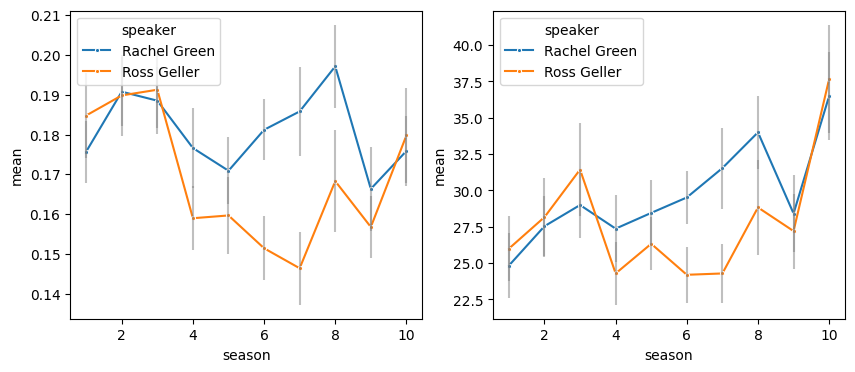

In [12]:
gen_df = df[(df['speaker'] == 'Rachel Green') | (df['speaker'] == 'Ross Geller')]

pr = gen_df.groupby(['speaker', 'season'])['pagerank'].agg(["mean", "sem"]).reset_index()
pr_rg1 = pr[pr['speaker'] == 'Ross Geller']
pr_rg2 = pr[pr['speaker'] == 'Rachel Green']

oc = gen_df.groupby(['speaker', 'season'])['outdegree'].agg(["mean", "sem"]).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey="col", sharex=True)
axs = axs.T.flatten()
## manually adding error bars is weird here because the sem is not directly recgonised for some reason
sns.lineplot(x="season", y="mean", hue="speaker", errorbar=('ci', 95), data=pr, 
             ax=axs[0],
            marker=".", )
axs[0].errorbar(
    x=pr['season'], y=pr['mean'], 
    yerr=pr['sem'], fmt='none', c='gray', alpha=0.5
) ## don't know why this bug is here mais bon
sns.lineplot(x="season", y="mean", hue="speaker",  data=oc, 
             ax=axs[1],
            marker=".")
axs[1].errorbar(
    x=oc['season'], y=oc['mean'], 
    yerr=oc['sem'], fmt='none', c='gray', alpha=0.5
) ## don't know why this bug is here mais bon


---

**1.7 —** **/True or false:/** Considering your answer in **1.6** are the following statements true or false? Justify your answer. 


A. "In season 7, Rachel Green's episode-level PageRank and out-degree centrality are higher than Ross Geller's. This difference is statistically significant at the 0.05 significance level."

B. "Phoebe Buffay's out-degree grew between season 1 and season 10; this implies that other characters spoke less than her in season 10."

C. "Phoebe Buffay's PageRank was higher in season 10 than in season 1. This difference is statistically significant at the 0.05 significance level and suggests that the character gained importance over the course of the show."


A is true because their error bars do not overlap
B is false because while it may be true, it is not necessarily true
C true now

## Part 2: The one about text similarity (40 pts)

Next, you investigate how unique characters are by analyzing what they said throughout the 10 seasons.

**2.1 —** Load the dataframe `exam3.jsonl`. This dataframe is similar to `exam1.jsonl`, except:

- It has an additional column called `tokens`, containing a sentence list. Each sentence is another list composed of tokens, e.g.,
`[['There', "'s", 'nothing', 'to', 'tell', '!'], ['He', "'s", 'just', 'some', 'guy', 'I', 'work', 'with', '!']]`.
- It has an additional column called `episode` containing a unique episode identifier.
- It only contains utterances by Phoebe, Rachel, Ross, Joey, Monica, or Chandler (the main characters).
 
Given this dataframe, you will create an episode-level word-frequency matrix for Chandler Bing, one of the main characters.

A. Create a list $L$ containing all distinct tokens uttered by Chandler Bing throughout the 10 seasons, sorted in ascending order. Print the 10 first and last elements of the list. 

B. Create a matrix $X$ with $m$ rows and $n$ columns, where: $n$ is the number of tokens in the list $L$ that you just created, and $m$ is the number of episodes (236). Each position $X_{i,j}$ in this matrix should contain the number of times the character uttered the word $j$ in episode $i$. Print how many times Chandler uttered the token `joey` in the first episode of the first season, as well as the shape of the matrix $X$.

C. Transform the matrix $X$ into a TF-IDF matrix $T$, combining the following formula (as seen in class):

$$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th episode}$$

$$\text{IDF}(j) =  \log \frac{\text{number of episodes}}{\text{number of episodes in which the $j$-th word occurs}}$$

Print the value in the TF-IDF matrix corresponding to Chandler's utterance of the token `joey` in the first episode of the first season.

D. **/Discuss:/** Some of the tokens (e.g., `joey`) reference other characters. How may these tokens help a classifier predict which character uttered a sentence?

In [64]:
###### correction, much more efficient

# A. Create a list L containing all distinct tokens 
df = pd.read_json("exam3.jsonl", lines=True) ## loading the data
df["tokens_flat"] = df["tokens"].apply(lambda xss: [x for xs in xss for x in xs])
# xs in lambda function => x is a list 
# xss => x is a list of list 
### => function splits the list of list into a flattenend list of tokens in the form of strings
### i.e. for every string in a list of strings in a list of list of strings x is in the list of strings

# Chandler only
dfc = df.loc[df["speaker"] == "Chandler Bing"] ## self-explanatory

# Creates token index
token_index = [x for xs in dfc["tokens_flat"] for x in xs]  # Flattens the list of lists into a single list of individual tokens (strings)
token_index = sorted(list(set(token_index)))  # Removes duplicates and sorts the tokens alphabetically

# major clarification would have been needed on their end: they wanted them in alphabetical order 
# while I tried to count them like an idiot


print("First 10 tokens", token_index[:10])
print(" Last 10 tokens", token_index[-10:])
dfc.head()

First 10 tokens ['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!!', '!..', '!...', '!?', '"']
 Last 10 tokens ['yummy', 'yup', 'zack', 'zero', 'zip', 'zone', 'zoo', 'zorps', '{', '}']


,id,conversation_id,text,speaker,reply-to,tokens,episode,tokens_flat
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01,"[all, right, joey, ,, be, nice, ., so, does, h..."
6,s01_e01_c01_u008,s01_e01_c01_u001,Sounds like a date to me.,Chandler Bing,s01_e01_c01_u007,"[[sounds, like, a, date, to, me, .]]",s01_e01,"[sounds, like, a, date, to, me, .]"
7,s01_e01_c01_u010,s01_e01_c01_u001,"Alright, so I'm back in high school, I'm stand...",Chandler Bing,s01_e01_c01_u009,"[[alright, ,, so, i, 'm, back, in, high, schoo...",s01_e01,"[alright, ,, so, i, 'm, back, in, high, school..."
8,s01_e01_c01_u012,s01_e01_c01_u001,"Then I look down, and I realize there's a phon...",Chandler Bing,s01_e01_c01_u011,"[[then, i, look, down, ,, and, i, realize, the...",s01_e01,"[then, i, look, down, ,, and, i, realize, ther..."
10,s01_e01_c01_u014,s01_e01_c01_u001,That's right.,Chandler Bing,s01_e01_c01_u013,"[[that, 's, right, .]]",s01_e01,"[that, 's, right, .]"


In [ ]:
# B. Create a matrix $X$ with $m$ rows and $n$ columns.

# Creates episode index
episode_index = [x for x in  dfc["episode"]]
episode_index = sorted(list(set(episode_index))) ## similarly returns a list with all of the episodes sorted
print(episode_index)

# Creates matrix
m, n = len(token_index), len(episode_index) ## je te jure qu'ils se sont trompés ici mais bon ce n'est pas particulièrement deep
X = np.zeros((m,n))

# Populates matrix
for tokens, episode in zip(dfc["tokens_flat"].values, dfc["episode"].values): ## tokens returns the list previously defined
    for token in tokens: ## iterates over every individual element of the list 
        X[token_index.index(token), episode_index.index(episode)] += 1
## .values is not always manatory, it returns the values of each of the elements in the form of a numpy array

## je m'étais fortement compliqué la vie

print(" How many times Chandler uttered the token joey in the first episode of the first season?",
      X[token_index.index("joey"), episode_index.index("s01_e01")])

print("X shape", X.shape)
# C. TF-IDF

# TF
TF = X
# IDF
IDF = np.log(X.shape[1]/np.count_nonzero(X, axis=1))
# TF-IDF
TF_IDF = TF * IDF[:, None]

print("joey on TF-IDF", TF_IDF[token_index.index("joey"), episode_index.index("s01_e01")])

In [13]:
### my work

## The dataframe is loaded
exam3_df = pd.read_json("exam3.jsonl", lines = True)
exam3_df.head()

,id,conversation_id,text,speaker,reply-to,tokens,episode
0,s01_e01_c01_u001,s01_e01_c01_u001,There's nothing to tell! He's just some guy I ...,Monica Geller,None,"[[there, 's, nothing, to, tell, !], [he, 's, j...",s01_e01
1,s01_e01_c01_u002,s01_e01_c01_u001,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,"[[c'mon, ,, you, 're, going, out, with, the, g...",s01_e01
2,s01_e01_c01_u003,s01_e01_c01_u001,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,"[[all, right, joey, ,, be, nice, .], [so, does...",s01_e01
3,s01_e01_c01_u004,s01_e01_c01_u001,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,"[[wait, ,, does, he, eat, chalk, ?]]",s01_e01
4,s01_e01_c01_u006,s01_e01_c01_u001,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,s01_e01_c01_u005,"[[just, ,, ', cause, ,, i, do, n't, want, her,...",s01_e01


In [27]:
#2.1.A
bingdf = exam3_df[exam3_df['speaker'] == 'Chandler Bing']

bingdf['tokens_sep'] = bingdf['tokens'].apply(lambda x: ' '.join([str(s) for s in x]));
bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace('[', ''))
bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace(']', ''))
bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace(',', ''))
bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace("'", ''))
bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace('"', ''))
token_counts=pd.Series()
for _, row in bingdf.iterrows():
    word_counts = pd.Series(row['tokens_sep'].split()).value_counts()
    token_counts = pd.concat([token_counts, word_counts], axis=0)
;

C:\Users\Karl Abdelnour\AppData\Local\Temp\ipykernel_24544\1262452083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bingdf['tokens_sep'] = bingdf['tokens'].apply(lambda x: ' '.join([str(s) for s in x]));
C:\Users\Karl Abdelnour\AppData\Local\Temp\ipykernel_24544\1262452083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bingdf['tokens_sep'] = bingdf['tokens_sep'].apply(lambda x: x.replace('[', ''))
C:\Users\Karl Abdelnour\AppData\Local\Temp\ipykernel_24544\1262452083.py:6: SettingWithCopyWarning: 

''

In [28]:
token_counts_df = pd.DataFrame(token_counts).reset_index()
#token_counts_df['index'] = token_counts_df['index'].apply(lambda x: x.replace('[', ''))
#token_counts_df['index'] = token_counts_df['index'].apply(lambda x: x.replace(']', ''))
#token_counts_df['index'] = token_counts_df['index'].apply(lambda x: x.replace(',', ''))
token_counts_df.columns=['token', 'count']
token_counts_df = token_counts_df.groupby('token')['count'].sum().reset_index()
token_counts_df.columns=['token', 'count']

In [29]:
#2.1.B
m = 236
n = token_counts_df.shape[0]
X = np.zeros((m, n))

numbered_ep = bingdf['episode'].unique()
episode_dict = {key: [] for key in numbered_ep}
for i in range(len(numbered_ep)):
    episode_dict[numbered_ep[i]] = i+1
bingdf['ep_n'] = bingdf['episode'].apply(lambda x: episode_dict[x])

C:\Users\Karl Abdelnour\AppData\Local\Temp\ipykernel_24544\2339996115.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bingdf['ep_n'] = bingdf['episode'].apply(lambda x: episode_dict[x])


In [30]:
token_counts_df.index = pd.RangeIndex(start= 1, stop =len(token_counts_df)+1)
token_counts_df.head()

,token,count
1,!,3161
2,!!,172
3,!!!,30
4,!!!!,5
5,!!!!!,1


In [53]:
bingdf_ep = bingdf.groupby('ep_n')['tokens_sep'].sum().reset_index()
bingdf_ep.columns=['ep_n', 'tokens']
bingdf_ep['tokens'].astype(str)
bingdf_ep.head()

,ep_n,tokens
0,1,all right joey be nice . so does he have a hu...
1,2,yeah i think for us kissing is pretty much l...
2,3,or you re such a nice guy means i m gon na ...
3,4,uh if i were omnipotent for a day i d .. mak...
4,5,we can ? all right i m tryin that .so satur...


In [ ]:
for index, row in token_counts_df.iterrows():
    for index2, row2 in bingdf_ep.iterrows():
        strings = row2['tokens'].split()
        if row['token'] in strings:
            X[index2, index] +=1

In [50]:
for tokens, episode in zip(bingdf_ep["tokens"], bingdf_ep["ep_n"]):
    for token in tokens:
        if token in token_counts_df['token']:  # Check if token exists in the index
            X[episode, token_counts_df.index.get_loc(token)] += 1

In [51]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [52]:
joey = token_counts_df[token_counts_df['token'] == "'joey'"].index
print(X[1, 2903])
print(X.shape)

0.0
(236, 6051)


---
For the remainder of the task, you will use the TF-IDF matrix that we compute below. Note:
- This matrix was calculated in a slightly different way: it considers only the 1000 tokens with the highest term frequency.
- We provide three useful variables below (`X`, `y`, and `df_tfidf`). 
    - `X` is a matrix containing the TF-IDF values for the top 1000 tokens, where each row corresponds to a character in an episode. 
    - `y` indicates which character is responsible for the utterance. Each character has a corresponding number, e.g., 2 for Monica Geller; see dictionary below. 
    - `df_tfidf` is a dataframe combining `X` with other episode and utterance-level metadata.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_tfidf = pd.read_json("exam3.jsonl", lines=True)[["speaker", "episode", "text"]]

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_tfidf.text).toarray()
print("X shape", X.shape)


map_char_to_int = {
'Chandler Bing': 0,
'Joey Tribbiani': 1,
'Monica Geller': 2,
'Phoebe Buffay': 3,
'Rachel Green': 4,
'Ross Geller': 5
}


y = df_tfidf.speaker.apply(lambda x: map_char_to_int[x]).values
print("y shape", y.shape)

df_tfidf = pd.concat([df_tfidf[["speaker", "episode"]],  pd.DataFrame(X)], axis=1)

df_tfidf.head(3)

X shape (51312, 1000)
y shape (51312,)


,speaker,episode,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,Monica Geller,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Joey Tribbiani,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Chandler Bing,s01_e01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- 

**2.2 —** To compare characters, carry out a classification task. Train a decision tree classifier to predict which main character uttered a sentence..

A. Split the dataset into training and test sets using sklearn `sklearn.model_selection.train_test_split` using parameters `test_size=0.3` and `random_state=42`, and using the default values for all other parameters.

B. Train a decision tree classifier (`sklearn.tree.DecisionTreeClassifier`) using `random_state=42`, leaving all other parameters as their default.

C. Compute the accuracy of your classifier and of a random baseline, i.e., a classifier that predicts a character uniformly at random. **/Discuss:/** Compare the two accuracies.


D. Compute the confusion matrix of your classifier using `sklearn.metrics.confusion_matrix`. Normalize the confusion matrix such that all cells sum to 1.

E. Plot an appropriate graphical representation of the confusion matrix.

F. **/Discuss:/** Analyzing the confusion matrix, discuss:
   - Which character is most distinct in the way they talk?
   - Which two characters are the most similar in the way they talk?
   - Which two characters are the least similar in the way they talk?


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [24]:
# 2.2.A
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#DT1 = DecisionTreeClassifier(random_state=42)
#DT1.fit(X_train, y_train) 

#y_pred = DT1.predict(y_test)
#DT1_accuracy = accuracy_score(y_test, y_pred) ## is the accuracy what they mean by evaluate? or just fit it?
#DT1_depth = DT1.get_depth()

In [25]:
## if DT1_accuracy>1/6 (i.e. random because there are 6 friends => good)

In [ ]:
df_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
map_int_to_char = {v: k for k, v in map_char_to_int.items()}
df_confusion.index = [map_int_to_char[x] for x in df_confusion.index]
df_confusion.index.name = "True"
df_confusion.columns =  [map_int_to_char[x] for x in df_confusion.columns]
df_confusion.T.index.name = "Predicted"
df_confusion = df_confusion / df_confusion.sum(axis=0).sum()
display(df_confusion)

# E.  Plot an appropriate graphical representation of the confusion matrix.
sns.heatmap(df_confusion, annot=True, fmt=".3f")

## employ these for this task 
## do not run as it will return an error

---

**2.3 —** **/Discuss:/** Last, you discuss the results obtained in **2.2** with a friend, who asks you some thought-provoking questions.

A. Your friend proposes that you should create a measure of similarity between two characters in a given episode in a more direct way than what you've done in **2.2**.  Propose (but do not implement) said similarity metric.

B. Your friend also suggests that your analysis might not truly capture how two characters differ. According to her, if people are in the same conversation, they might speak similarly simply because they are in the same social context. Propose (but do not implement) a way of creating a dataset where this confounder does not exist.

C. Last, your friend complains about how you present your (normalized) confusion matrix. According to her, from reading the cells alone, it is unclear if the fraction of occurrences is higher or lower than what a random classifier would yield. Propose (but do not implement) a way of modifying the confusion matrix to address her concern.


In [ ]:
####

---